#### Final Report (Group #36) DSCI 100 006
### Predicting the Presence of Heart Disease

**Group Members: Sadia Khan Durani, Jia Jun Liu, Jessica DeBiasio, Quynh Cao**

## _INTRO:_


**Our Predictive Question :  Can age, resting blood pressure, cholestoral levels, and maximum heart rate achieved accurately predict the diagnosis of heart disease?**

Heart disease is an increasingly prevalent condition affecting a multitude of different people globally. Heart disease refers to a multitude of different heart conditions such as coronary artery disease and cardiomyopathy ("About Heart Disease", 2022). These debilitating conditions contribute annually to 1 in 4 American deaths every year (2022), making prompt diagnosis and treatment of these conditions of grave importance. Though the onset of these conditions vary, generally there are certain risk factors which can contribute to a heart disease diagnosis. These factors can include high blood pressure, physical inactivity, and high blood cholesterol (2022). Understanding these risk factors and finding individuals who may have them could lead to a more prompt diagnosis of these diseases and thus more effective treatment.

Our project aims to investigate if age, resting blood pressure, cholesterol levels and maximum heart rate of an individual can be predictors of a heart disease diagnosis. In understanding the predictive ability of these four variables more reliable diagnosis options can be explored to help patients before the onset of debilitating heart disease. 

The data set we will use to explore this predictive problem is a compiled heart disease data set from Kaggle.com. This data set contains information on multiple onset heart disease risk factors of individuals admitted to the hospital for acute chest pain with patient data from 4 different global locailites spanning from 1988 onwards. This data set includes information about the age, sex, cheat pain type (from 0-4), the resting blood pressure, serum cholestoral level in the blood, the fasting blood sugar, the maximum heart rate achieved, the presence of exercise induced angina, the number of major vessels (from 0-3). and the diagnosis of the blood disorder thalassemia with 0 as normal, 1 as fixed defect and 2 as reversible defect. Additionally, there is data about results of electrocardiogram tests including the resting electrocardiographic results (values 0-2), the ST depression value and the slope of the ST segment. 

Lastly, there is data on the presence of heart disease in the patient with:
 * 0 indicating no heart disease 
 * 1 indicating the presence of heart disease. 


In [2]:
# Load the packages and set the seed

library(tidyverse)
library(repr)
library(tidymodels)
library(dplyr)
library(GGally)
library(gtable)
library(grid)
library(gridExtra)

options(repr.matrix.max.rows = 6)
set.seed(2022) 

## _Methods/Results --> Analysis:_ 

We will be using the KNN Classification method to predict the presence of heart disease since what we're predicting is categorical

#### ***1) Loading our data:***
- Below, we first load our dataset through a URL since the required packages are loaded above. We also set the seed (above) to have consistent randomness. We do adjustments to the dataset, such as converting our categorical variable to a factor and removing the repeated observations with the unique() function. We then select the relevant predictors instead of the entire dataset for our analysis which we stated in our proposal:

    * We had visualized the training data using the ggpairs() function to plot the columns against each other that can effectively show which columns we could use as our predictors. We chose the 4 selected below as predictors (age, trestbps, chol, thalach, target) based on the scatter plots which showed the points in sorts of groups which indicates that they have a relation and are best to use.


In [3]:
url <- "https://raw.githubusercontent.com/sadia-kd/DSCI-Project/main/heart.csv"

heart_disease <- read_csv(url) %>%
    mutate(target = as_factor(target)) %>%
    unique() %>%
    select(age, trestbps, chol, thalach, target)

heart_disease

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_double(),
  thal = col_double(),
  target = col_double()
)



age,trestbps,chol,thalach,target
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
52,125,212,168,0
53,140,203,155,0
70,145,174,125,0
⋮,⋮,⋮,⋮,⋮
52,128,255,161,0
59,160,273,125,0
54,120,188,113,0


_Figure 1.1: Loaded Heart Disease Dataset with selected columns_

### Exploring The Data

#### ***2) Split the dataset into training/testing data sets***

- Before visualizing our data, we split it into the training/testing sets using the initial_split() function so that we can perform a summary of the training data set that is relevant for exploratory data analysis related to our planned analysis 

    * We also split our training set to have a proportion of 75% of the dataset so that we can train our model with a good amout in the training set, and use the remaining 25% to test our model and evaluate it since the model would have never seen those observations.


In [4]:
# spliting the data into training/testing sets

heart_disease_split <- initial_split(heart_disease, prop = 0.75, strata = target)
heart_disease_train <- training(heart_disease_split)
heart_disease_test <- testing(heart_disease_split) 


#### ***3) Explore the data (exploratory data analysis)***

- Next, the 3 cells below are examples of how we analyzed our data:

1) The first one is a table which shows the number of observations in each class in the training set and the % of each class present which will be identical to the % in the entire dataset. This dataset has about 46% of cases with no heart disease and about 54% with heart disease. This proves that overall, our data is balanced between the 2 classes.

2) The second cell indicates that our data has no missing data

3) Finally, the third cell is a 'summary' to show more information about the dataset, e.g. mean/min/max values for our predictors and again the number of observations for each class for our categorical variable we are predicting ('target' variable in our dataset)

In [6]:
# Summarize the training DATA 

obs <- nrow(heart_disease_train)

data_count <- heart_disease_train %>%
    group_by(target) %>%
    summarize(count = n(), percentage = n()/obs * 100)
data_count

`summarise()` ungrouping output (override with `.groups` argument)



target,count,percentage
<fct>,<int>,<dbl>
0,104,45.81498
1,123,54.18502


_3.1 Table: The number of observations in training data_

In [7]:
sum(is.na(heart_disease_train))

[1] 0

In [8]:
summary(heart_disease_train)

      age          trestbps          chol          thalach      target 
 Min.   :34.0   Min.   : 94.0   Min.   :126.0   Min.   : 71.0   0:104  
 1st Qu.:47.0   1st Qu.:120.0   1st Qu.:212.0   1st Qu.:133.0   1:123  
 Median :56.0   Median :130.0   Median :240.0   Median :152.0          
 Mean   :54.6   Mean   :131.9   Mean   :244.8   Mean   :149.1          
 3rd Qu.:61.0   3rd Qu.:140.0   3rd Qu.:273.5   3rd Qu.:165.0          
 Max.   :76.0   Max.   :192.0   Max.   :417.0   Max.   :195.0          

_3.2 Table: Summary of training data_

### Visualization of the data

#### ***4) Visualize the data (before the analysis)***
- Below, we visualize our data, before that, we also separately scale and center the data here to normalize the data and use this to get more affective plots. There were differences in how each column were measured, therefore, scaling and centering will help with accuracy.

In [9]:
# scale and center + prep and bake to inspect the result of the preprocessing steps 

scaled_heart_disease <- recipe(target  ~ ., data = heart_disease_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) %>%
    prep() %>%
    bake(heart_disease_train)

scaled_heart_disease

age,trestbps,chol,thalach,target
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
-0.1788826,0.4776845,-0.8727205,0.2608543,0
0.7135645,0.9470973,-0.8727205,0.5279849,0
0.8251204,0.3603312,1.0251411,-1.9207117,0
⋮,⋮,⋮,⋮,⋮
-0.29043846,-0.2264348,0.2117718,0.5279849,0
0.49045277,1.6512166,0.5871731,-1.0747984,0
-0.06732668,-0.6958477,-1.1855549,-1.6090594,0


_4.1 Table: Scaled and Centered Training Set_

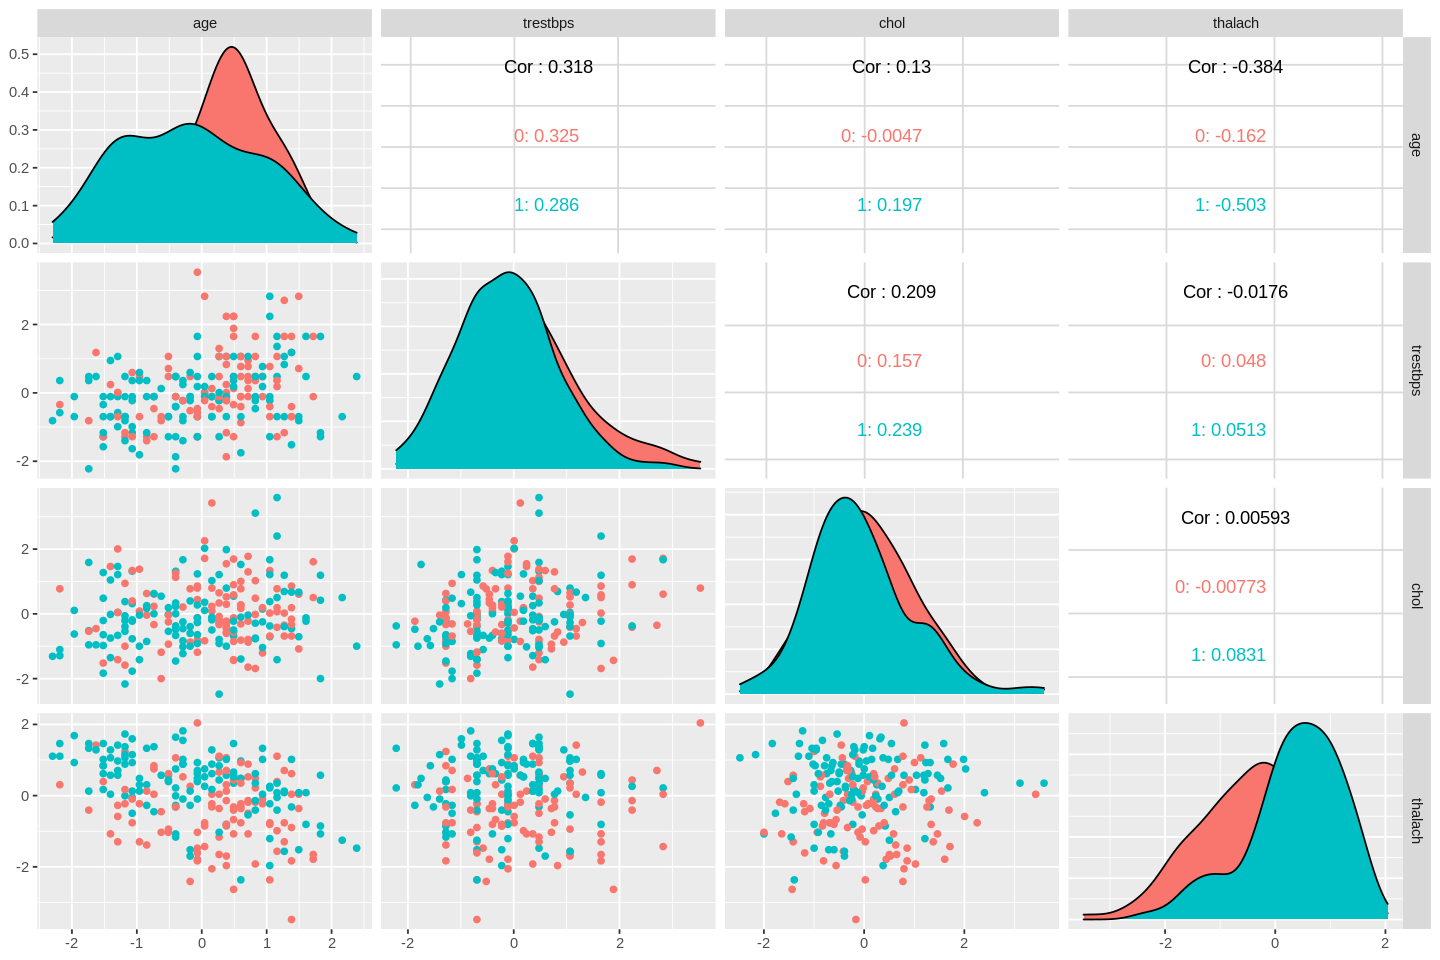

In [10]:
# Plot all appropriate columns against each other, and colour by the target
options(repr.plot.width = 12, repr.plot.height = 8) 

plots <- ggpairs(scaled_heart_disease, mapping = aes(color = target), columns = 1:4)

plots

_4.2 Figure: Matrix plot of all the predictors_

- The above matrix plot indeed shows that there are differense present between the predictors as we colour the plots by "target" which is the columnn that states whether there is heart disease or not

### _Performing the Analsyis_

#### ***5) Tuning our model:***

- To find the best K value, we first tune the model using a 5-fold cross validation method on the training set and then we plot the accuracy vs # of neighbors to illustrate which K value has the highest accuracy. We use 5-fold cross validation method because that will allow us to train five different models which will assist in our understanding of our model. We also pik 5 because we are limited by computational power, meaning if we chose 10 folds instead, the computation would take longer.

- We have already selected the specific columns we will need in the beginning when loading the data
#### Begin with creating the model (tuning it)

In [11]:
# Set the seed. Don't remove this!
set.seed(2022) 

# Preprocessing the data 

heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
        set_engine("kknn") %>%
        set_mode("classification")

heart_recipe <- recipe(target ~. , data = heart_disease_train) %>%
        step_scale(all_predictors()) %>%
        step_center(all_predictors())

- Next,  we create the 5-fold cross-validation on the training set
- AND, we create a data frame with a neighbors variable that contains the sequence of values of K to try, containing values from 1 to 100 (stepping by 5) to get a large range of values to check.

In [12]:
# Set the seed. Don't remove this!
set.seed(2022)

# 5-fold cross-validation
vfold <- vfold_cv(heart_disease_train, v = 5, strata = target)

# tibble of k-vals
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

- Now, we put it all together in a workflow, and use the collect_metrics() function to obtain and in a table format to view the results produced by tuning 

In [13]:
# Set the seed. Don't remove this!
set.seed(2022)

# Putting it in a workflow

heart_disease_workflow <- workflow() %>%
        add_recipe(heart_recipe) %>%
        add_model(heart_spec) %>%
        tune_grid(resamples = vfold, grid = k_vals) %>%
        collect_metrics()
heart_disease_workflow

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6082345,5,0.01695131,Model01
1,roc_auc,binary,0.6052857,5,0.01751160,Model01
6,accuracy,binary,0.6385727,5,0.01221243,Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
91,roc_auc,binary,0.7310774,5,0.01900421,Model19
96,accuracy,binary,0.6438076,5,0.02306173,Model20
96,roc_auc,binary,0.7336349,5,0.02147386,Model20


_5.1 Table: Sequence of values of K_

- Now we extract "accuracy", from the .metric column because the rest of the observations are not necessary for our analysis in creating the model. 
- Then we plot the the Accuracy VS K-values to determine which number of neighbors is best to use in our knn-classification

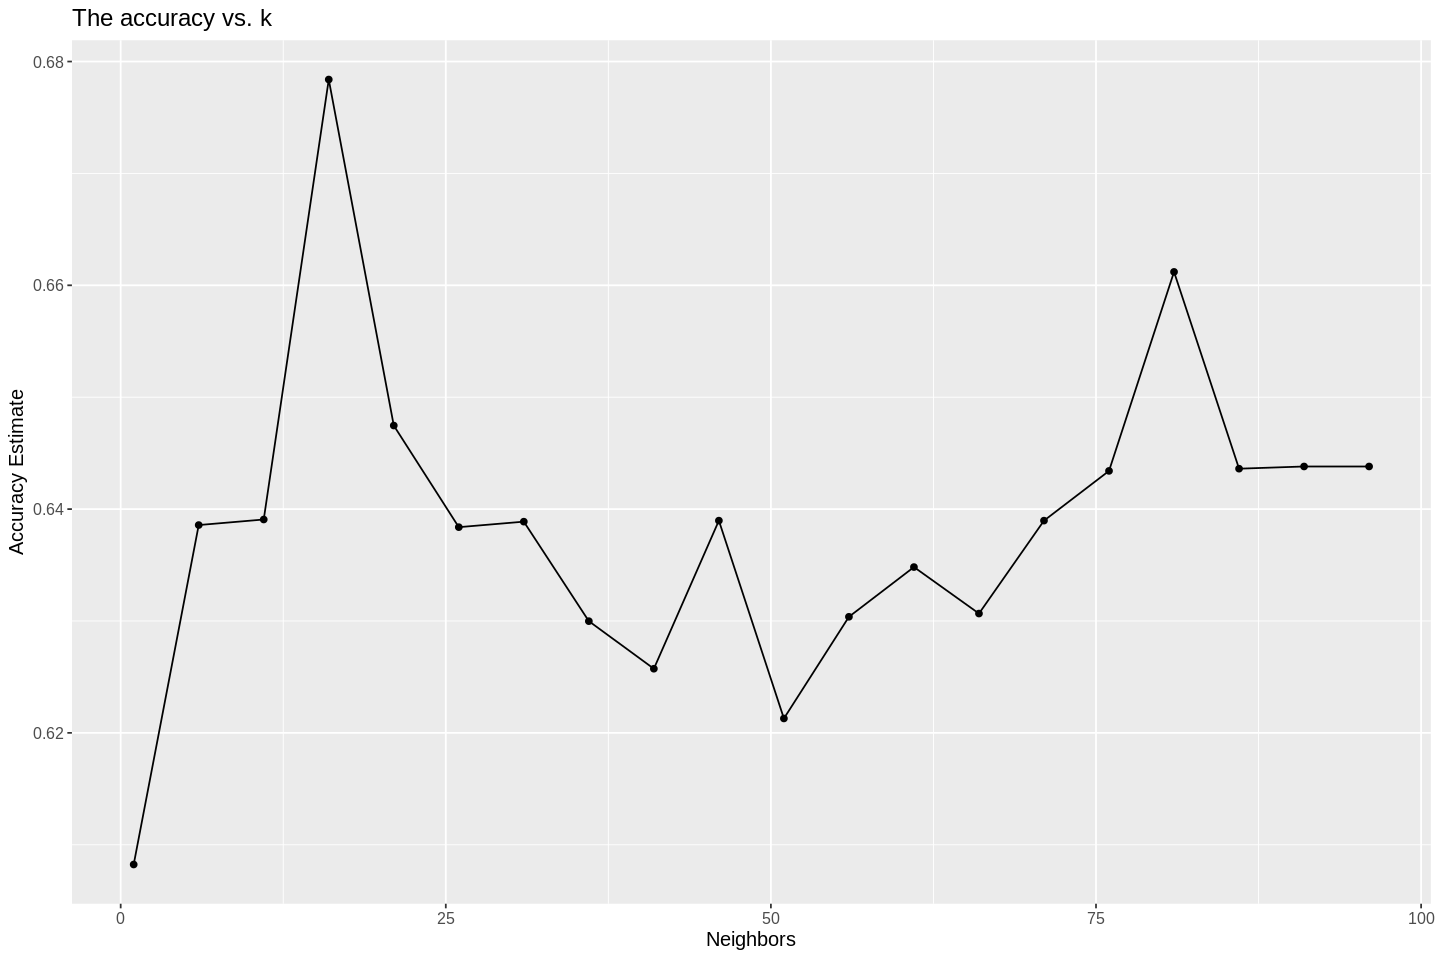

In [14]:
# Accuracy VS K-values

accuracies <- heart_disease_workflow %>% 
        filter(.metric == "accuracy") 

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line() +
        labs(x = "Neighbors", y = "Accuracy Estimate") +
        theme(text = element_text(size = 12)) +
        ggtitle("The accuracy vs. k")

accuracy_vs_k

_5.2 Figure: Plot of estimated accuracy vs. the # of neighbors_

- It might be difficult reading the # of Neighbors from the line plot above, that is why we do the following below to extract the actual k-value.

In [15]:
# Find the # Neighbors through data

k_accurate <- heart_disease_workflow %>% 
        filter(.metric == "accuracy") %>%
        arrange(mean) %>%
        tail(1) %>%
        pull(neighbors)

k_accurate

[1] 16

#### ***6) Re-train our model with the K value obtained and perform K-nearest neighbor classification:***

- We will now use the highest K found to re-train our model and then test our model by predicting the testing set

##### **The k-value which we found that provides the highest accurate model is 16, we will now use this and re-do our knn classification to predict our test set**

#### Build Our Final Model

In [16]:
# Set the seed. Don't remove this!
set.seed(2022)

# use neighbors = 16
# create new model but use the same recipe as nothing changes there

best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 16) %>%
        set_engine("kknn") %>%
        set_mode("classification")

Knn_fit <- workflow() %>%
        add_recipe(heart_recipe) %>%
        add_model(best_spec)%>%
        fit(data = heart_disease_train)

Knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~16, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3436123
Best kernel: rectangular
Best k: 16

#### Predit the heart_disease_test set now
- We can now use the predict() function to predict our test set, and then view how accurately our model predicts the test set by adding the predicted column, and filtering for "accuracy"

In [17]:
data_predicted <- predict(Knn_fit, heart_disease_test) %>%
        bind_cols(heart_disease_test)

data_predicted_matrix <- data_predicted %>%
        metrics(truth = target, estimate = .pred_class) %>%
        filter(.metric == "accuracy")

data_predicted_matrix

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.72


_6.1 Table: Accuracy % with K=16_

#### ***7) Result Analysis & Visualization:***

- We create a visualization of our analysis by creating the confusion matrix and plotting that to clearly tell the different cases and # in each case.

In [18]:
conf_mat <- data_predicted %>%
    conf_mat(truth = target, estimate = .pred_class)
conf_mat

          Truth
Prediction  0  1
         0 22  9
         1 12 32

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



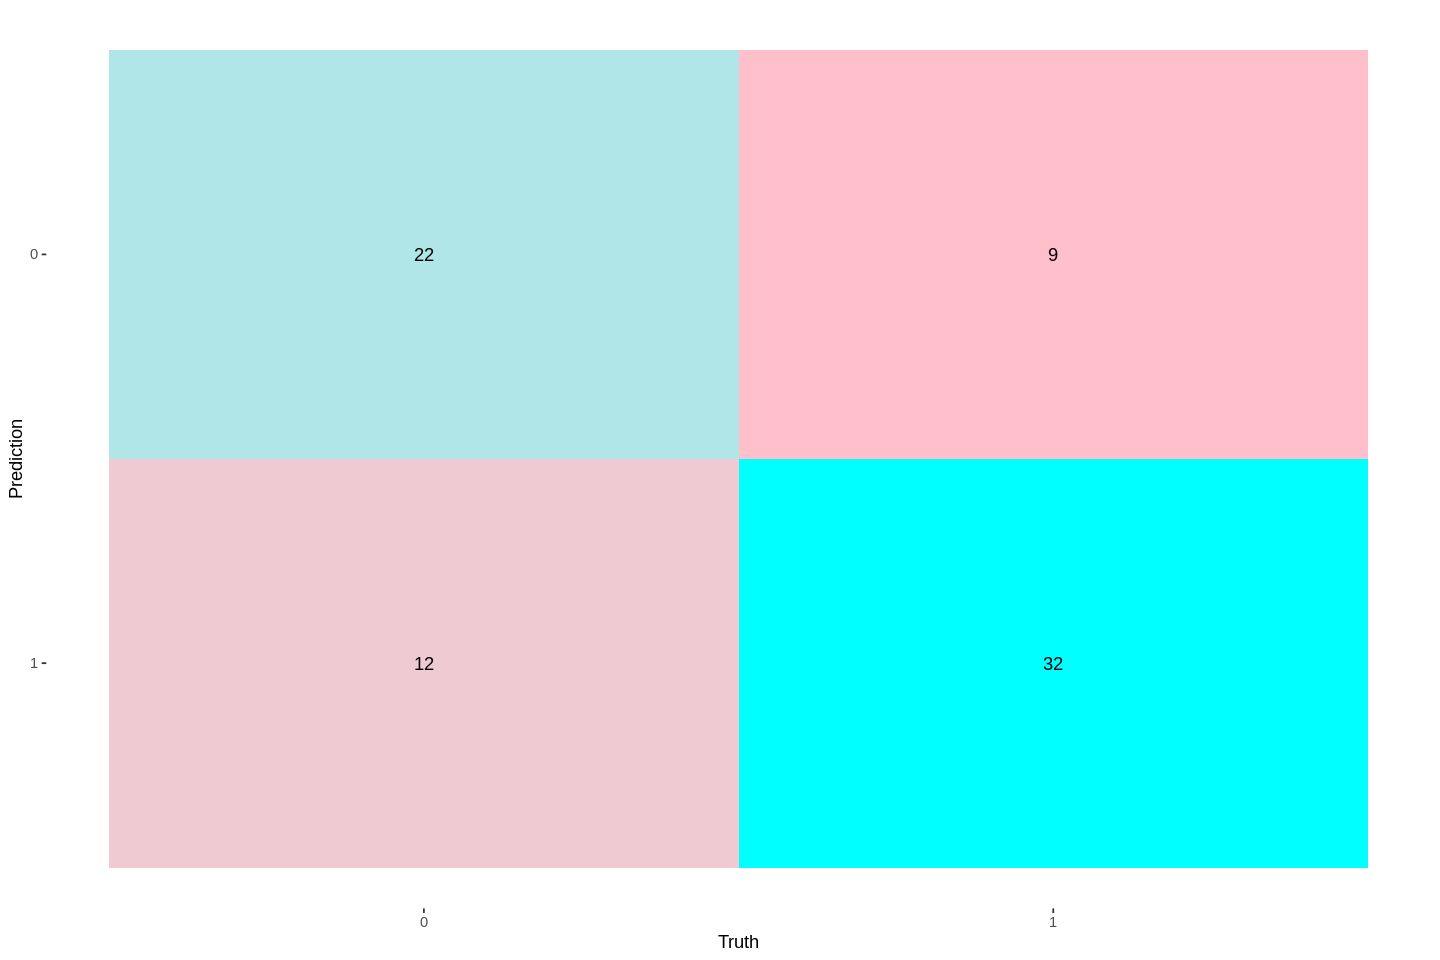

In [19]:
autoplot(conf_mat, type = "heatmap") +
  scale_fill_gradient(low = "pink", high = "cyan")

## Final Discussion 

Using the combination of the four predictors, age, resting blood pressure, serum cholesterol level in the blood, and maximum heart rate achieved; our classification model provides 72% accuracy of prediction for heart disease diagnosis on the testing set. Analyzing the accuracy through a confusion matrix allows us to understand what this accuracy means and its implications in a medical setting. Through the confusion matrix, we see that of the 75 predictions our model made, 21 resulted in a misdiagnosis. Of these 21 misdiagnoses, 9 were false negatives where the patient had heart disease but was not diagnosed. This is a grave error in our classification model which could result in a patient not receiving proper medical attention leading to a worsening of the condition. This accuracy result means that if this classification model were to be used in a practical setting for heart disease diagnosis,  for 1 000 000 patients, 280 000 of them would be incorrectly diagnosed with 120 000 of those being false negatives. As we initially aimed for a classification model that would enhance the reliability and efficiency of heart disease screening, 72% accuracy is not desirable for this medical diagnosis. 


Several factors can explain the lower-than-expected accuracy of the model. One of the leading causes is the limited use of risk-factor classification predictors. While the exploratory data visualizations suggested the most appropriate predictive combination available from the dataset, the model has ignored other information on chest pain type, the fasting blood sugar, the presence of exercise-induced angina the number of major vessels the diagnosis of the blood disorder thalassemia, electrocardiogram results including the resting electrocardiographic results, the ST depression value, and the slope of the ST segment. These are all common heart disease risk-factors and medical tests that cardiologists would use in order for heart disease diagnoses (2020; 2022). Additionally, this dataset only includes results from specific cardiac tests that would return quantitative values. Since several commonly ordered tests imaging tests such as Magnetic resonance imaging (MRI), Coronary computed tomography angiogram (CCTA), or chest X-ray are also essential for structural abnormality detection (2020; 2022); the absence of this information would also further lower the predictive ability of the model which emphasizes the use of a combination of risk-factors and medical tools to provide accurate diagnosis. On the other hand, heart disease is a general label for different subtypes of deficient heart conditions and each condition might vary widely in risk-factors and symptoms (2022). Therefore, the exclusive use of age, resting blood pressure, cholesterol levels, and maximum heart rates achieved as predictors might not be efficient enough to compensate for the variability, resulting in less precise predictions by the model.

Understanding this model's accuracy has highlighted the importance of using relevant risk-factors and cartographic tests to reliably diagnose heart disease. For further work on making an essential predictive model like this, our work suggests the need to refine the types of risk-factors used as predictors and include potentially important ones that are currently absent, like genetic composition (“About Heart Disease”, 2022) . This refining lends itself to preventing the overgeneralization of the multitude of different heart diseases into one simple diagnosis, as we had seen in our model.  Pairing and comparing the predicted results with further designated models of the heart disease subtypes classification would reduce variability and provide more in-depth diagnosis. Additionally, it is also important to consider how the number of different predictors affects the performance of the K-nearest neighbor classification algorithm. To create a more accurate diagnosis model while also still integrating these important risk-factors, more advanced classification methods should be developed. The improvement of this model could allow for these deadly diseases to be detected earlier allowing for swift treatment while also creating more questions for data analysts and medical researchers alike to investigate on. 

# ***8) More Result Analysis:***

- To give some more visualizations on our model, and how the observations present in dataset are, we redo an analysis on 2 predictors at a time and visualize the top 3 with a coloured plot.

### _Evaluate accuracy for all cases with their best K (Combination of each two variables at a time) in order to be able to visualize a 2-D plot_

##### _We learn the following from the Variable selection method referred to as best subset selection in the textbook (Beale, Kendall, and Mann 1967; Hocking and Leslie 1967). - DSCI 100 Textbook Chapter 6.8_


- We create a separate model for every possible subset of predictors, tune each one using cross-validation, and pick the subset of predictors that gives us the highest cross-validation accuracy.
- We do these steps after our model with all the predictors in order to visualize the analysis through different methods. For the best visualization, we only pick two variables out of four. 
- Total is 6 cases which is C(4 ,2).

#### Find the K with highest accuracy for all 6 cases 

- Create a function to get a plot to visualize k vs accuracy
- Choose some candidate values of K (1 to 20)
- For each K, train the model using traning set only
- Evaluate accuracy for each using validation set only
- Apply cross-validation technique - splitting multiple ways and averaging
- Pick the K that maximizes validation accuracy

In [20]:
# age:1 trestbps:2 chol:3 thalach:4
predictors = c("age","trestbps","chol","thalach")

In [24]:
#Create plots to visualizae finding the best K value

get_k_accuracy_plot = function(predIndex1, predIndex2){
        #set seed
        set.seed(2022)
        
        #create formula
        formula = paste("target", "~", paste(predictors[predIndex1],sep = "+", predictors[predIndex2]))
        
        # tune spec for all cases
        knn_tune = nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
                      set_engine("kknn") %>%
                      set_mode("classification")
    
        # create function for creating recipe
        heart_recipe_2 = recipe(as.formula(formula),data = heart_disease_train) %>%
                        step_scale(all_predictors()) %>%
                        step_center(all_predictors())
        
        # Use the same 5-fold cross-validation object from the main model
        vfold_2 = vfold_cv(heart_disease_train, v = 5, strata = target)

        # Create a data frame with a neighbors variable that contains the sequence of values of K to try. 
        k_vals = tibble(neighbors = seq(from = 1, to = 20))
        
        # Get accuracy from different k
        knn_results = workflow() %>%
                       add_recipe(heart_recipe_2) %>%
                       add_model(knn_tune) %>%
                       tune_grid(resamples = vfold_2, grid = k_vals) %>%
                       collect_metrics()

        accuracies = knn_results %>%
                      filter(.metric == "accuracy")

        plot_title = paste("Neighbors vs accuracy estimate for k values: ", paste(predictors[predIndex1],sep = " and ", predictors[predIndex2]))    
    
        accuracy_versus_k = ggplot(accuracies, aes(x = neighbors, y = mean)) +
                             geom_point() +
                             geom_line() +
                             xlim(0,20) +
                             labs(x = "Neighbors", y = "Accuracy Estimate", title = plot_title) +
                             theme(text = element_text(size = 10)) 
        
    }

#### Apply function to each case

In [25]:
# case1: age vs trestbps
k_accuracy_plot_age_tre = get_k_accuracy_plot(1,2)

# case2: age vs chol
k_accuracy_plot_age_cho = get_k_accuracy_plot(1,3)

# case3: age vs thalach
k_accuracy_plot_age_tha = get_k_accuracy_plot(1,4)

# case4: trestbps vs chol
k_accuracy_plot_tre_cho = get_k_accuracy_plot(2,3)

# case5: trestbps vs thalach 
k_accuracy_plot_tre_tha = get_k_accuracy_plot(2,4)

# case6: chol vs thalach
k_accuracy_plot_cho_tha = get_k_accuracy_plot(3,4)

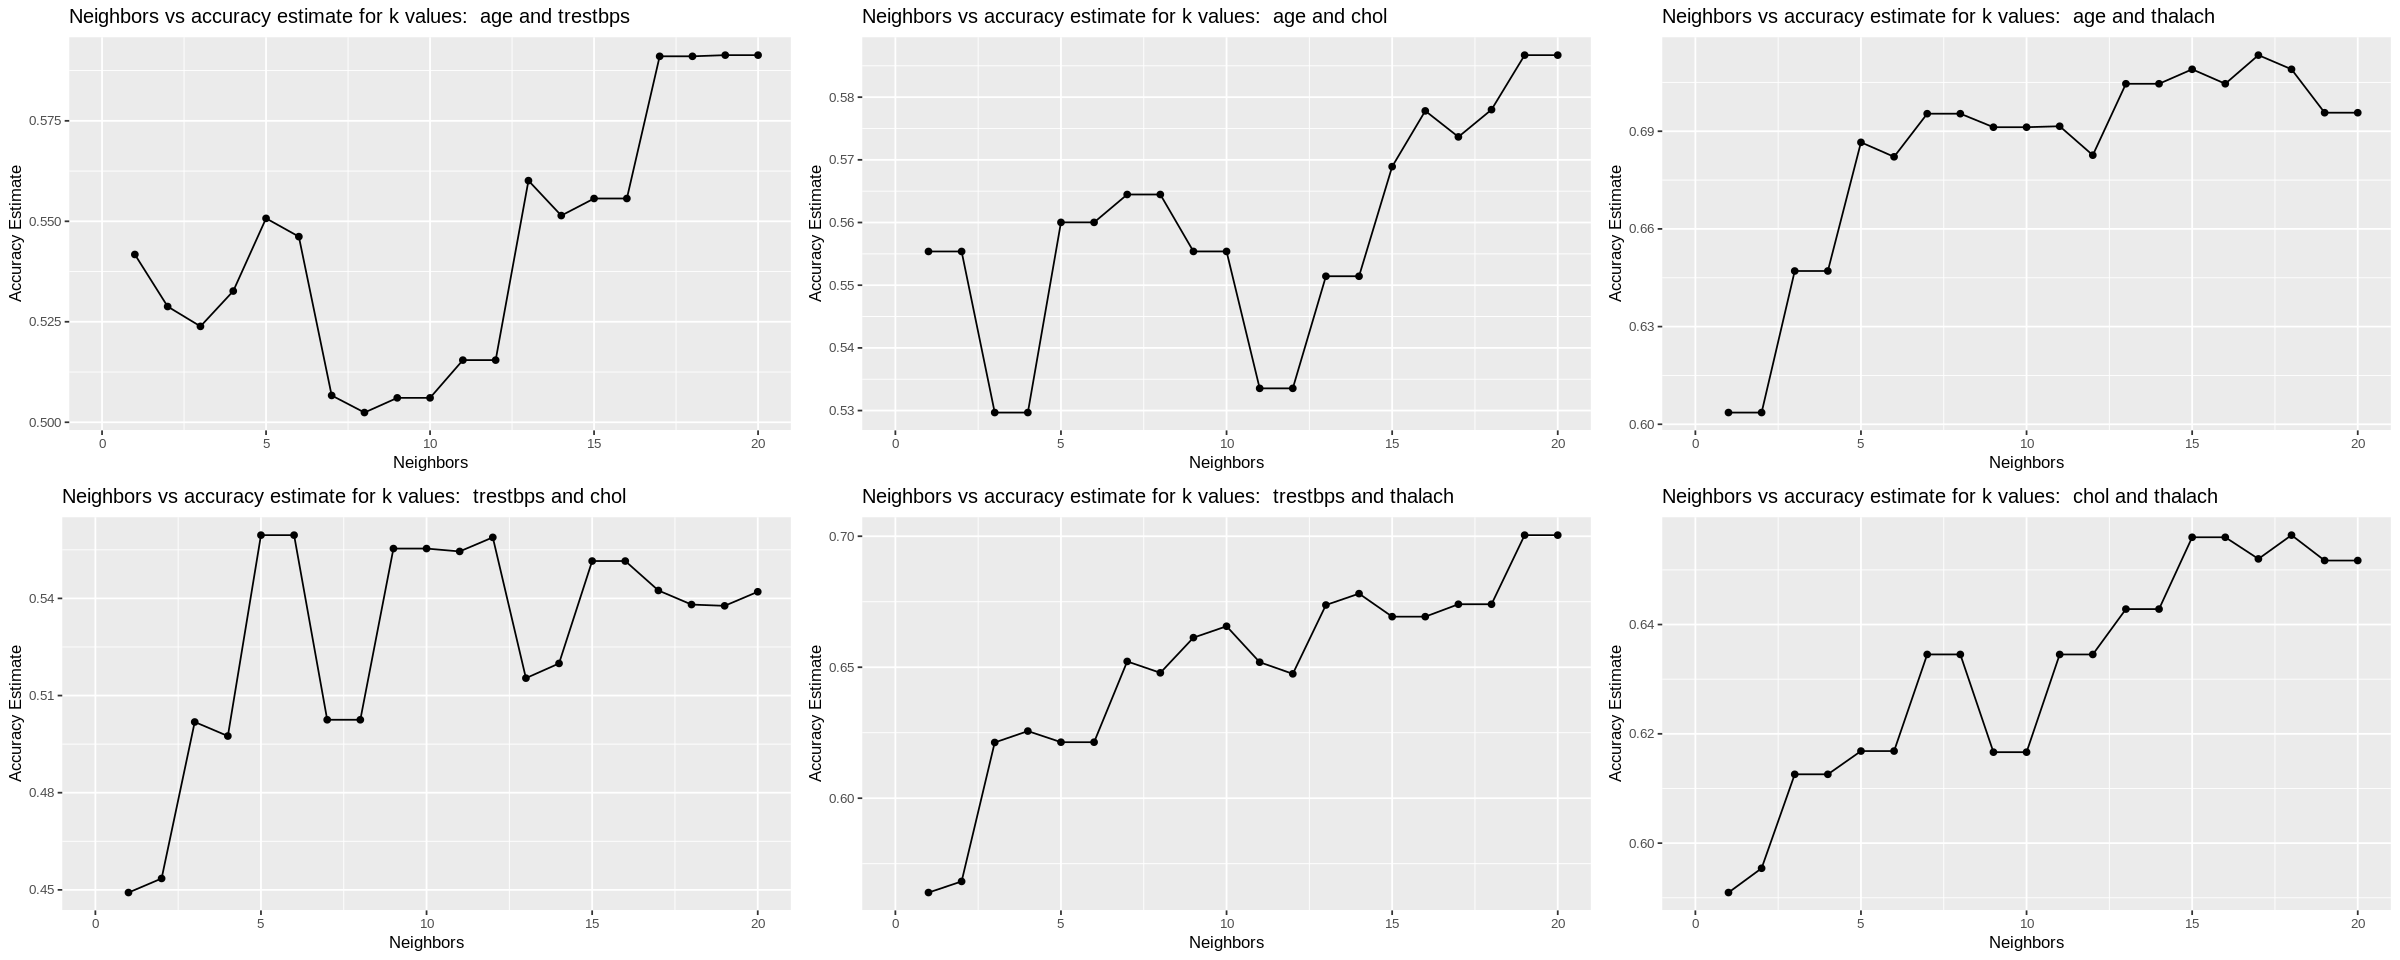

In [26]:
options(repr.plot.width = 20, repr.plot.height = 8)
grid.arrange(k_accuracy_plot_age_tre, k_accuracy_plot_age_cho,k_accuracy_plot_age_tha,k_accuracy_plot_tre_cho,k_accuracy_plot_tre_tha,k_accuracy_plot_cho_tha,
            nrow=2,ncol=3)

_7.1 Figure: Plot of estimated accuracy vs. the # of neighbors for each set of predictors (2 at a time)_

#### From above plots, we can get the best K for each cases:

- case1: age vs trestbps: k = 20
- case2: age vs chol: k = 20
- case3: age vs thalach: k = 17
- case4: trestbps vs chol: k = 12
- case5: trestbps vs thalach: k = 20
- case6: chol vs thalach: k = 15

#### Classification for all cases

- Pick out our two desired predictor variables and class label and store them as a new data set
- Create a model specification for K-nearest neighbors classification by calling the nearest_neighbor function.
- Pass the model specification and the dataset to the fit function
- Now we can use the predict function to predict our testing data.
- Use the bind_cols function to add the column of predictions to the original test data
- Apply function metrics() to extract accuracy for all cases with their best K

In [27]:
get_predictions = function(predIndex1, predIndex2, k){
        #set seed
        set.seed(2022)
        
        #create formula
        formula = paste("target", "~", paste(predictors[predIndex1],sep = "+", predictors[predIndex2]))
        
        # tune spec for all cases
        knn_spec_2 = nearest_neighbor(weight_func = "rectangular", neighbors = k) %>%
                      set_engine("kknn") %>%
                      set_mode("classification")
    
        # create function for creating recipe
        heart_recipe_2 = recipe(as.formula(formula),data = heart_disease_train) %>%
                        step_scale(all_predictors()) %>%
                        step_center(all_predictors())
        
        # Get accuracy from different k
        heart_fit = workflow() %>%
                       add_recipe(heart_recipe_2) %>%
                       add_model(knn_spec_2) %>%
                       fit(data = heart_disease_train)
    
        # Do prediction and save result to the data frame
        predictions = predict(heart_fit,heart_disease_test) %>%
                        bind_cols(heart_disease_test)
        
    }

In [28]:
# case1: age vs trestbps, where k = 20
predictions_age_tre = get_predictions(1,2,20)

# case2: age vs chol, where k = 20
predictions_age_cho = get_predictions(1,3,20)

# case3: age vs thalach, where k = 17
predictions_age_tha = get_predictions(1,4,17)

# case4: trestbps vs chol, where k = 12
predictions_tre_cho = get_predictions(2,3,12)

# case5: trestbps vs thalach, where k = 20
predictions_tre_tha = get_predictions(2,4,20)

# case6: chol vs thalach, where k = 15
predictions_cho_tha = get_predictions(3,4,15)

In [29]:
# case1: age vs trestbps
prediction_accuracy_age_tre = predictions_age_tre %>%
        metrics(truth = target, estimate = .pred_class) %>%
        filter(.metric == "accuracy") %>%
        select(.estimate) %>%
        pull()
# case2: age vs chol
prediction_accuracy_age_cho = predictions_age_cho %>%
        metrics(truth = target, estimate = .pred_class)%>%
        filter(.metric == "accuracy") %>%
        select(.estimate) %>%
        pull()  
# case3: age vs thalach
prediction_accuracy_age_tha = predictions_age_tha %>%
        metrics(truth = target, estimate = .pred_class)%>%
        filter(.metric == "accuracy") %>%
        select(.estimate) %>%
        pull()  
# case4: trestbps vs chol
prediction_accuracy_tre_cho = predictions_tre_cho %>%
        metrics(truth = target, estimate = .pred_class)%>%
        filter(.metric == "accuracy") %>%
        select(.estimate) %>%
        pull()  
# case5: trestbps vs thalach
prediction_accuracy_tre_tha = predictions_tre_tha %>%
        metrics(truth = target, estimate = .pred_class)%>%
        filter(.metric == "accuracy") %>%
        select(.estimate) %>%
        pull()  
# case6: chol vs thalach
prediction_accuracy_cho_tha = predictions_cho_tha %>%
        metrics(truth = target, estimate = .pred_class)%>%
        filter(.metric == "accuracy") %>%
        select(.estimate) %>%
        pull() 

Combination = c("age vs trestbps", "age vs chol", "age vs thalach", "trestbps vs chol", "trestbps vs thalach","chol vs thalach")
Accuracy = c(prediction_accuracy_age_tre,prediction_accuracy_age_cho,prediction_accuracy_age_tha,
              prediction_accuracy_tre_cho,prediction_accuracy_tre_tha,prediction_accuracy_cho_tha)

df = data.frame(Combination,Accuracy) %>%
        arrange(desc(Accuracy))
df

Combination,Accuracy
<chr>,<dbl>
age vs thalach,0.7466667
trestbps vs thalach,0.7333333
chol vs thalach,0.7333333
age vs trestbps,0.6533333
trestbps vs chol,0.5866667
age vs chol,0.5733333


_7.2 Table: Accuracy for each case with the K found_

- Therefore, we will use the above, trestbps and thalach, chol and thalach for classification to visualize our analysis with each 2 predictors at a time.

## Visualize accuracy via Colored Prediction Map

- #### Age vs Thalach, using k = 20

In [30]:
# create the grid of vals, and arrange in a data frame
a_grid <- seq(min(heart_disease_train$age), 
                max(heart_disease_train$age), 
                length.out = 100)
b_grid <- seq(min(heart_disease_train$thalach), 
                max(heart_disease_train$thalach), 
                length.out = 100)
asgrid <- as_tibble(expand.grid(age = a_grid, 
                                thalach = b_grid))
# set spec 
knn_spec_3 = nearest_neighbor(weight_func = "rectangular", neighbors = 20) %>%
                set_engine("kknn") %>%
                set_mode("classification")
    
# create function for creating recipe
heart_recipe_3 = recipe(target~ age + thalach ,data = heart_disease_train) %>%
                step_scale(all_predictors()) %>%
                step_center(all_predictors())
        
# Get accuracy from different k
heart_fit = workflow() %>%
                add_recipe(heart_recipe_3) %>%
                add_model(knn_spec_3) %>%
                fit(data = heart_disease_train)
# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(heart_fit, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid)

# plot:
# 1. the colored scatter of the original data
# 2. the faded colored scatter for the grid points
wkflw_plot <-
  ggplot() +
  geom_point(data = heart_disease_train, 
             mapping = aes(x = age, 
                           y = thalach, 
                           color = target), 
             alpha = 0.75) +
  geom_point(data = prediction_table, 
             mapping = aes(x = age, 
                           y = thalach, 
                           color = .pred_class), 
             alpha = 0.02, 
             size = 5) +
  labs(color = "Heart Disease", 
       x = "age", 
       y = "thalach",
      title = "Colored prediction map using age and thalach, where k is 15") +
  scale_color_manual(labels = c("Yes", "No"), 
                     values = c("orange2", "steelblue2")) +
  theme(text = element_text(size = 12))

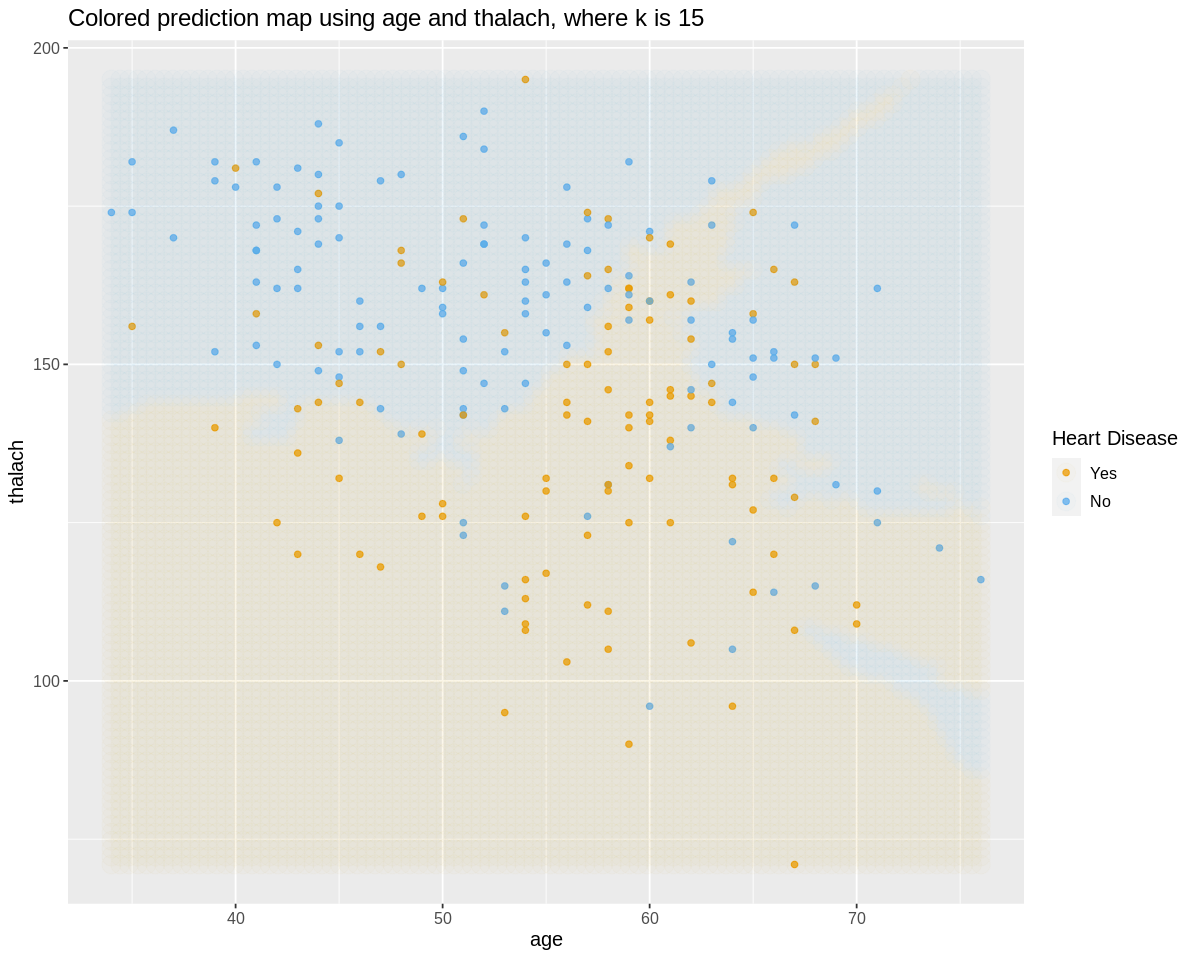

In [31]:
options(repr.plot.width = 10, repr.plot.height = 8)
wkflw_plot

_7.4 Figure: Color prediction map using predictors Age and Thalach_

- #### Trestbps vs Thalach, using k = 20

In [32]:
# create the grid of vals, and arrange in a data frame
a_grid <- seq(min(heart_disease_train$trestbps), 
                max(heart_disease_train$trestbps), 
                length.out = 100)
b_grid <- seq(min(heart_disease_train$thalach), 
                max(heart_disease_train$thalach), 
                length.out = 100)
asgrid <- as_tibble(expand.grid(trestbps = a_grid, 
                                thalach = b_grid))
# set spec 
knn_spec_4 = nearest_neighbor(weight_func = "rectangular", neighbors = 20) %>%
                set_engine("kknn") %>%
                set_mode("classification")
    
# create function for creating recipe
heart_recipe_4 = recipe(target~ trestbps + thalach ,data = heart_disease_train) %>%
                step_scale(all_predictors()) %>%
                step_center(all_predictors())
        
# Get accuracy from different k
heart_fit = workflow() %>%
                add_recipe(heart_recipe_4) %>%
                add_model(knn_spec_4) %>%
                fit(data = heart_disease_train)
# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(heart_fit, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid)

# plot:
# 1. the colored scatter of the original data
# 2. the faded colored scatter for the grid points
wkflw_plot <-
  ggplot() +
  geom_point(data = heart_disease_train, 
             mapping = aes(x = trestbps, 
                           y = thalach, 
                           color = target), 
             alpha = 0.75) +
  geom_point(data = prediction_table, 
             mapping = aes(x = trestbps, 
                           y = thalach, 
                           color = .pred_class), 
             alpha = 0.02, 
             size = 5) +
  labs(color = "Heart Disease", 
       x = "trestbps", 
       y = "thalach",
      title = "Colored prediction map using trestbps and thalach, where k is 14") +
  scale_color_manual(labels = c("Yes", "No"), 
                     values = c("orange2", "steelblue2")) +
  theme(text = element_text(size = 12))

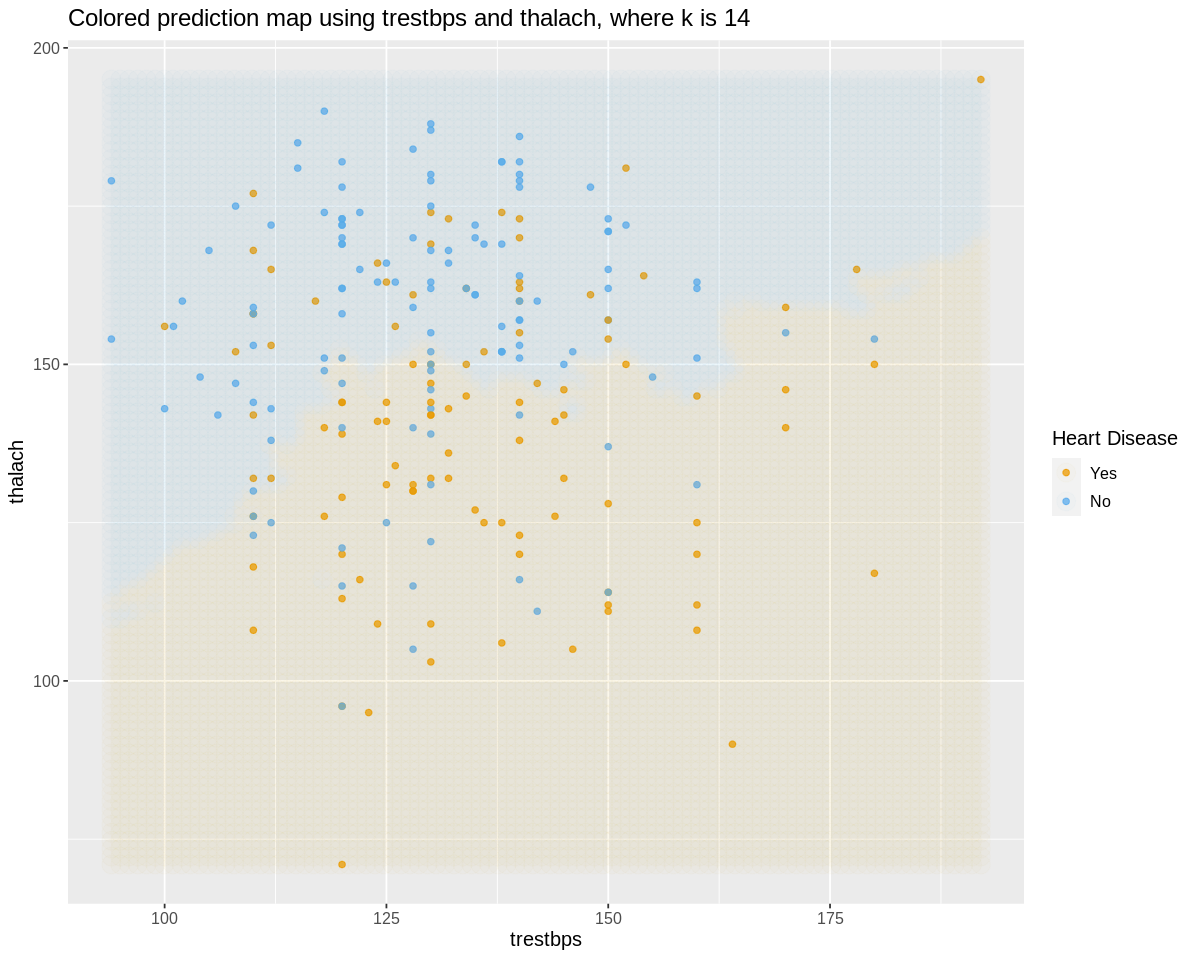

In [33]:
options(repr.plot.width = 10, repr.plot.height = 8)
wkflw_plot

_7.5 Figure: Color prediction map using predictors Trestbps and Thalach_

- #### Chol vs Thalach, using k = 15

In [34]:
# create the grid of vals, and arrange in a data frame
a_grid <- seq(min(heart_disease_train$chol), 
                max(heart_disease_train$chol), 
                length.out = 100)
b_grid <- seq(min(heart_disease_train$thalach), 
                max(heart_disease_train$thalach), 
                length.out = 100)
asgrid <- as_tibble(expand.grid(chol = a_grid, 
                                thalach = b_grid))
# set spec 
knn_spec_5 = nearest_neighbor(weight_func = "rectangular", neighbors = 15) %>%
                set_engine("kknn") %>%
                set_mode("classification")
    
# create function for creating recipe
heart_recipe_5 = recipe(target~ chol + thalach ,data = heart_disease_train) %>%
                step_scale(all_predictors()) %>%
                step_center(all_predictors())
        
# Get accuracy from different k
heart_fit = workflow() %>%
                add_recipe(heart_recipe_5) %>%
                add_model(knn_spec_5) %>%
                fit(data = heart_disease_train)
# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(heart_fit, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid)

# plot:
# 1. the colored scatter of the original data
# 2. the faded colored scatter for the grid points
wkflw_plot <-
  ggplot() +
  geom_point(data = heart_disease_train, 
             mapping = aes(x = chol, 
                           y = thalach, 
                           color = target), 
             alpha = 0.75) +
  geom_point(data = prediction_table, 
             mapping = aes(x = chol, 
                           y = thalach, 
                           color = .pred_class), 
             alpha = 0.02, 
             size = 5) +
  labs(color = "Heart Disease", 
       x = "chol", 
       y = "thalach",
      title = "Colored prediction map using chol and thalach, where k is 15") +
  scale_color_manual(labels = c("Yes", "No"), 
                     values = c("orange2", "steelblue2")) +
  theme(text = element_text(size = 12))

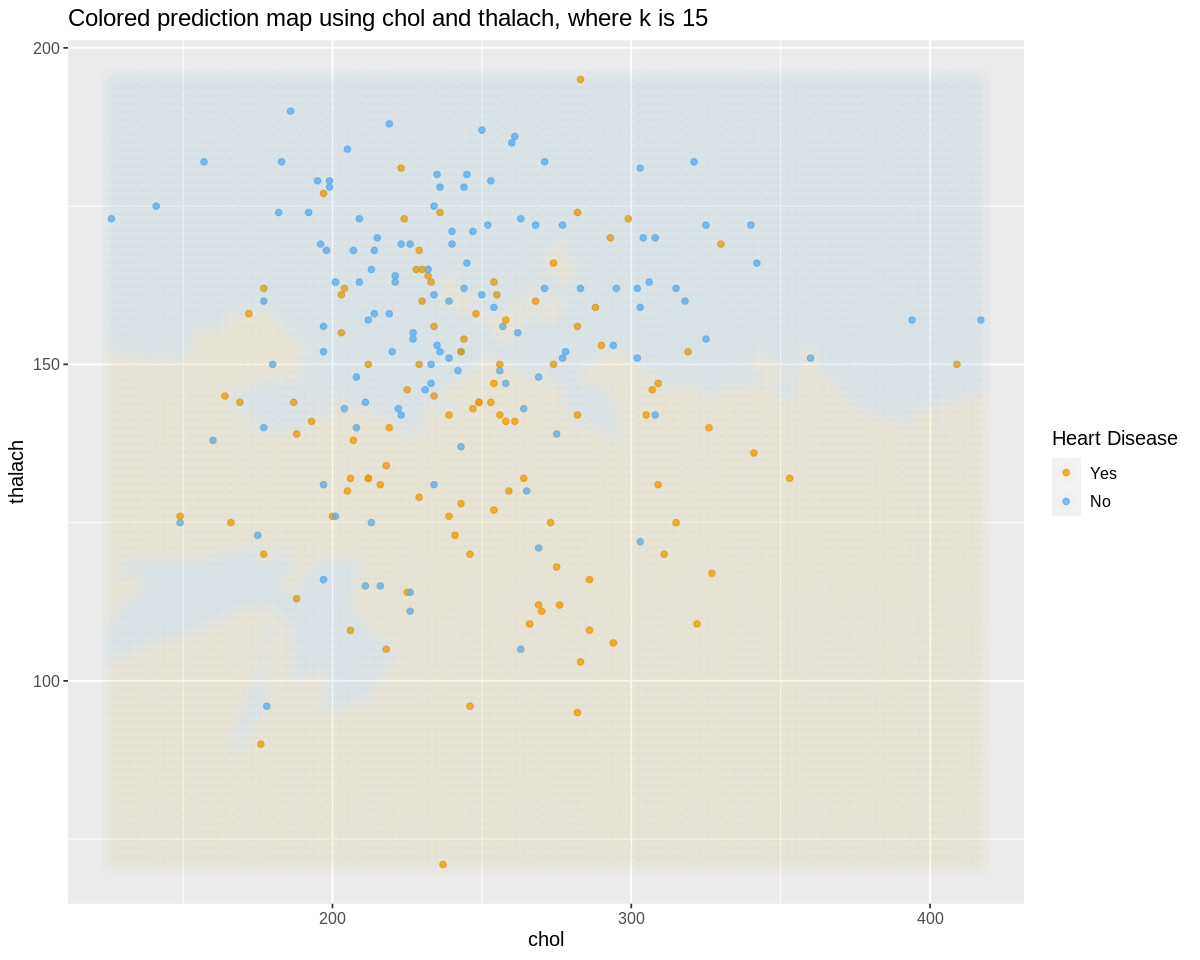

In [35]:
options(repr.plot.width = 10, repr.plot.height = 8)
wkflw_plot

_7.6 Figure: Color prediction map using predictors Chol and Thalach_

### References:

These were the following references that we used to help our analysis by understanding the dataset we are working with about Heart Disease

- Dataset Source: Lapp, D. (2019). Heart Disease Dataset (Kaggle.com) https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset

- 1) About Heart Disease. (2022). Retrieved 25 March 2022, from https://www.cdc.gov/heartdisease/about.htm
- 2) 10 Heart Tests Your Doctor Might Order, and What They Mean. (2020). Retreived 7 April 2022, from https://healthblog.uofmhealth.org/heart-health/10-heart-tests-your-doctor-might-order-and-what-they-mean 